In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import time

from sklearn.metrics import make_scorer, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_model_metrics(test_data, model, model_name):
    '''''''''
    Get binary classification metrics for a given model and saves the results to local directory
    '''''''''
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [3]:
# Set the path to your data folders
data_folder = "../../Data/A_PESO"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

# Extract GLCM features

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
def extract_features(image_path):
    image = cv2.imread(image_path, 0)  # Read the image in grayscale
    if image is None or image.size == 0:
        raise ValueError(f"Image at {image_path} could not be loaded")

    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def extract_features_train(image):
    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def load_data(folder):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    features = extract_features(image_path)
                    data.append(features)
                    labels.append(subfolder)
                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    normalized_data = normalize_features(np.array(data))
    return normalized_data, labels

def load_data_train(folder, augmentations_per_image=1):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    image = cv2.imread(image_path, 0)
                    if image is None or image.size == 0:
                        continue

                    original_features = extract_features_train(image)
                    data.append(original_features)
                    labels.append(subfolder)

                    for _ in range(augmentations_per_image):
                        image_aug = aug.augment_image(image)
                        augmented_features = extract_features_train(image_aug)
                        data.append(augmented_features)
                        labels.append(subfolder)

                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    return np.array(data), labels

# Anterior placental planes

In [6]:
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [8]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [9]:
scorer = make_scorer(f1_score, pos_label=1)

In [10]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 100, 'class_weight': None, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.2633333333333333
7.339094877243042


In [11]:
best_params = grid_search.best_params_

In [12]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [13]:
best_svc_clf.fit(X_train, y_train)

SVC(C=100, gamma=0.01, probability=True, random_state=42)

Best threshold: 0.14 with F1-score: 0.25


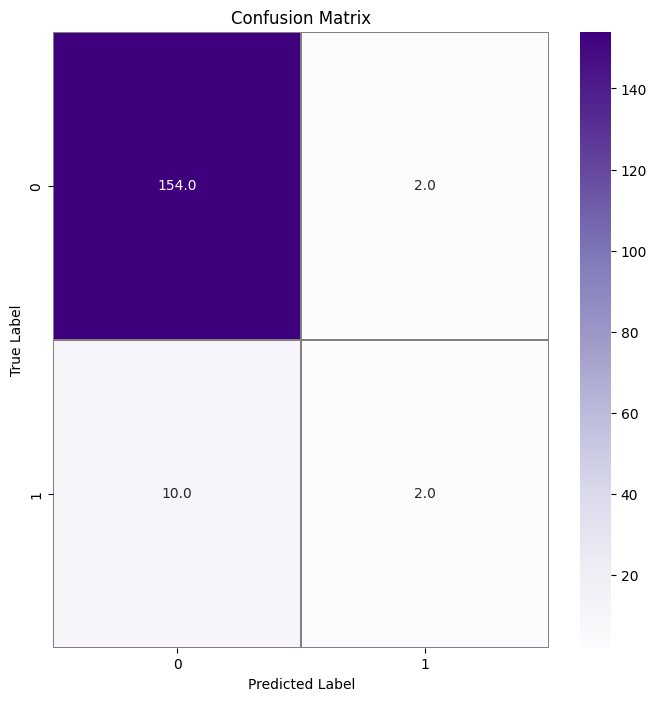

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       156
           1       0.50      0.17      0.25        12

    accuracy                           0.93       168
   macro avg       0.72      0.58      0.61       168
weighted avg       0.91      0.93      0.91       168

                     Model Name   AUC  F1-Score Positive Class  Accuracy   
0  PESO-SVC-noaug-poly-anterior  0.49                     0.25      0.93  \

   Sensitivity  Specificity  PPV   NPV   PLR   NLR  
0         0.17         0.99  0.5  0.94  13.0  0.84  


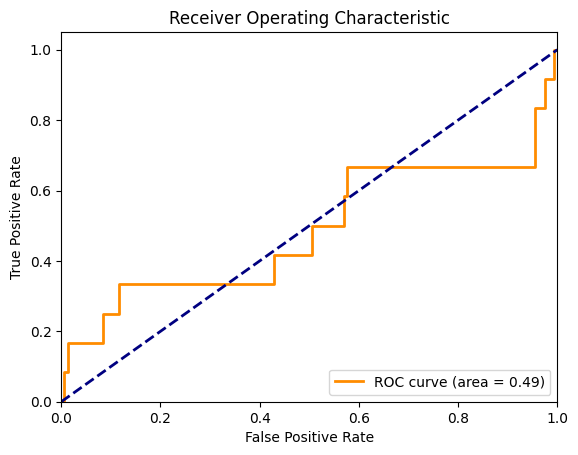

In [14]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='PESO-SVC-noaug-poly-anterior')

In [15]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1, 'class_weight': 'balanced'}
Best Score: 0.1908608058608059
2.3113210201263428


In [16]:
best_params = grid_search.best_params_

In [17]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [18]:
best_svc_clf.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', probability=True, random_state=42)

Best threshold: 0.08 with F1-score: 0.16


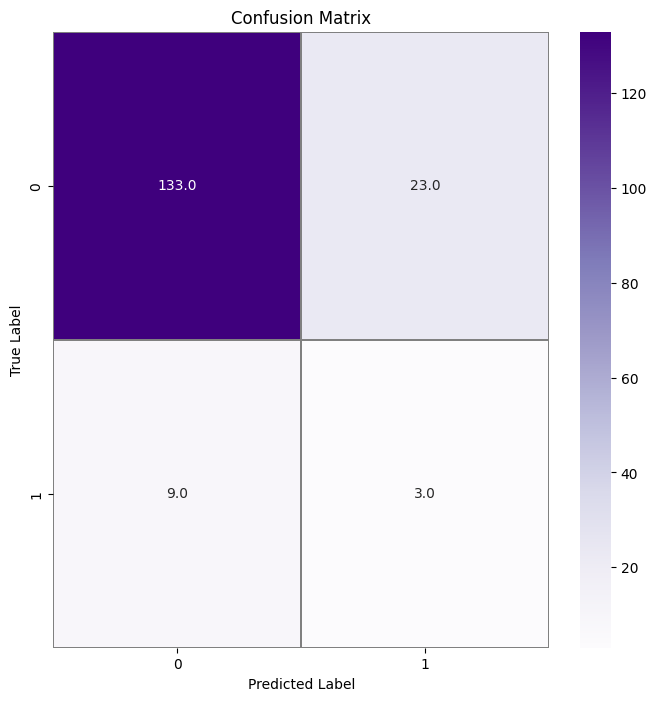

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       156
           1       0.12      0.25      0.16        12

    accuracy                           0.81       168
   macro avg       0.53      0.55      0.53       168
weighted avg       0.88      0.81      0.84       168

                       Model Name   AUC  F1-Score Positive Class  Accuracy   
0  PESO-SVC-noaug-linear-anterior  0.44                     0.16      0.81  \

   Sensitivity  Specificity   PPV   NPV  PLR   NLR  
0         0.25         0.85  0.12  0.94  1.7  0.88  


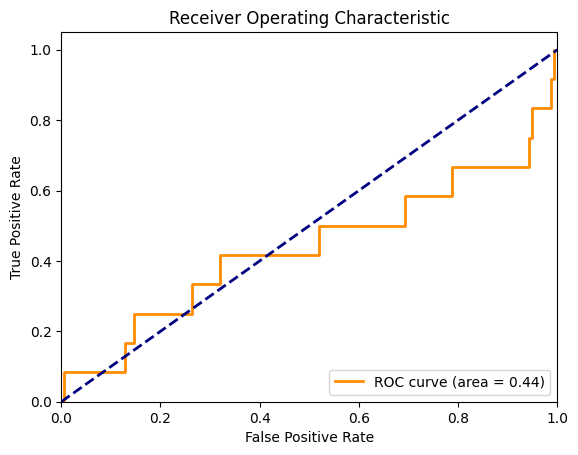

In [19]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='PESO-SVC-noaug-linear-anterior')

# Posterior placental planes

In [20]:
# Set the path to your data folders
data_folder = "../../Data/P_PESO"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

In [21]:
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [23]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [24]:
scorer = make_scorer(f1_score, pos_label=1)

In [25]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 10000, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.2333333333333333
4.594661235809326


In [26]:
best_params = grid_search.best_params_

In [27]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [28]:
best_svc_clf.fit(X_train, y_train)

SVC(C=10000, gamma=0.001, probability=True, random_state=42)

Best threshold: 0.03 with F1-score: 0.16


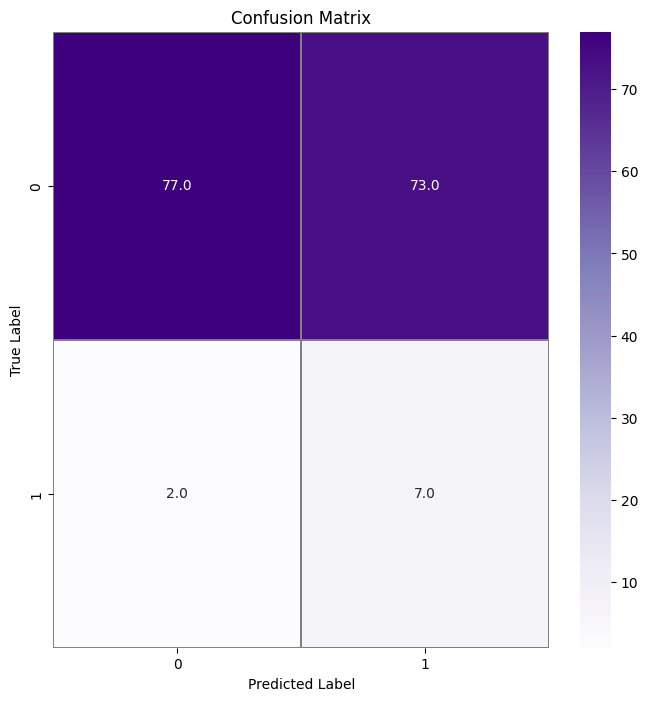

              precision    recall  f1-score   support

           0       0.97      0.51      0.67       150
           1       0.09      0.78      0.16         9

    accuracy                           0.53       159
   macro avg       0.53      0.65      0.41       159
weighted avg       0.92      0.53      0.64       159

                      Model Name   AUC  F1-Score Positive Class  Accuracy   
0  PESO-SVC-noaug-poly-posterior  0.55                     0.16      0.53  \

   Sensitivity  Specificity   PPV   NPV  PLR   NLR  
0         0.78         0.51  0.09  0.97  1.6  0.43  


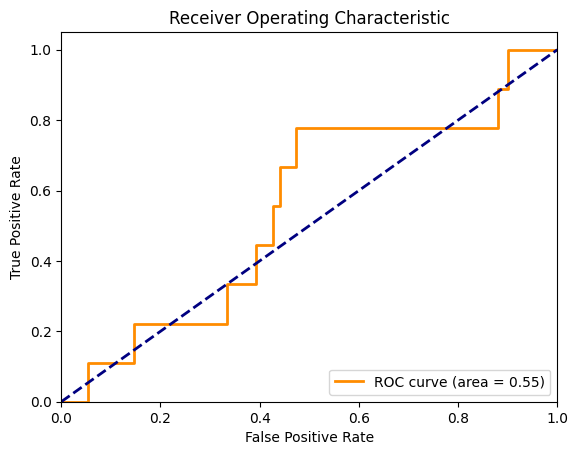

In [29]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='PESO-SVC-noaug-poly-posterior')

In [30]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1, 'class_weight': 'balanced'}
Best Score: 0.19000000000000003
1.3954510688781738


In [31]:
best_params = grid_search.best_params_

In [32]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [33]:
best_svc_clf.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', probability=True, random_state=42)

Best threshold: 0.08 with F1-score: 0.20


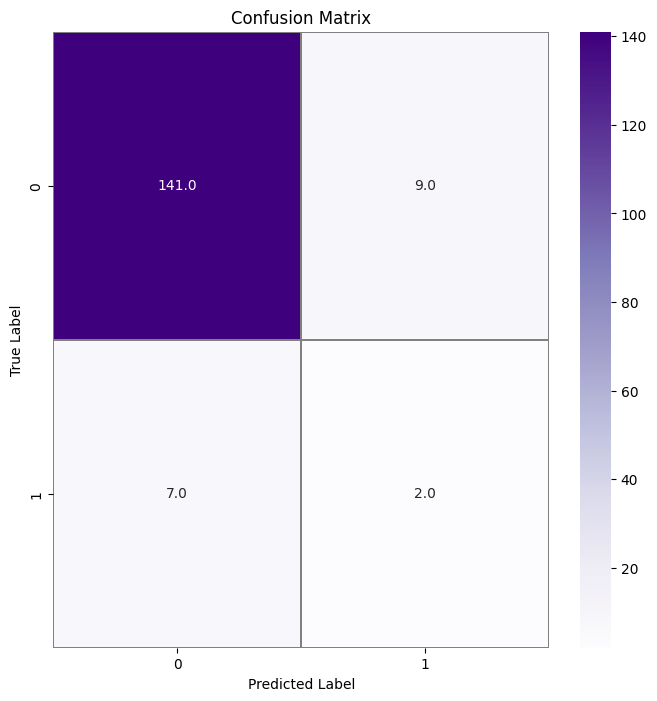

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       150
           1       0.18      0.22      0.20         9

    accuracy                           0.90       159
   macro avg       0.57      0.58      0.57       159
weighted avg       0.91      0.90      0.90       159

                      Model Name   AUC  F1-Score Positive Class  Accuracy   
0  PESO-SVC-noaug-poly-posterior  0.59                      0.2       0.9  \

   Sensitivity  Specificity   PPV   NPV  PLR   NLR  
0         0.22         0.94  0.18  0.95  3.7  0.83  


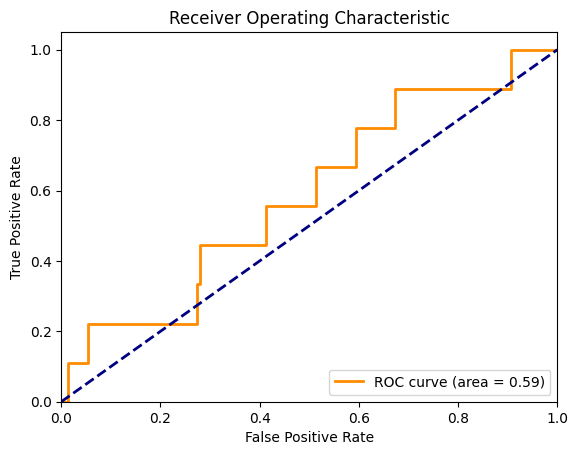

In [34]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='PESO-SVC-noaug-poly-posterior')